In [1]:
# Download data

# !git clone https://github.com/JeffSackmann/tennis_atp

In [2]:
# Import libraries

import re
import os
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    KFold,
    GridSearchCV,
)

from sklearn.metrics import (
    auc,
    roc_curve,
    classification_report,
)

In [3]:
# Defining datasets to use

# os.chdir("tennis_atp")
ext = ".csv"

start_year = 2014
end_year = 2024

file_path = "/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/"

# matches_file = "atp_matches_"
# players_file = "atp_players.csv"

rankings = [
    "atp_rankings_70s.csv",
    "atp_rankings_80s.csv",
    "atp_rankings_90s.csv",
    "atp_rankings_00s.csv",
    "atp_rankings_10s.csv",
    "atp_rankings_20s.csv",
    "atp_rankings_current.csv",
]


In [4]:
players_df = pd.read_csv(os.path.join(file_path, "atp_players.csv"))
players_df.head()

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
1,100002,Pancho,Segura,R,19210620.0,ECU,168.0,Q54581
2,100003,Frank,Sedgman,R,19271002.0,AUS,180.0,Q962049
3,100004,Giuseppe,Merlo,R,19271011.0,ITA,NaN,Q1258752
4,100005,Richard,Gonzalez,R,19280509.0,USA,188.0,Q53554


## Data Preprocessing

In [5]:
# Concatenate matches data

dataframes = []
for year in range(start_year, end_year+1):
    p = os.path.join(file_path, f"atp_matches_{str(year) + ext}")
    print(p)
    df = pd.read_csv(p)
    dataframes.append(df)

matches_df = pd.concat(dataframes)
matches_df.head()

/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2014.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2015.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2016.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2017.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2018.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2019.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2020.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2021.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2022.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2023.csv
/Users/katecastillo/Documents/MSDS/atp-tennis-predictions/tennis_atp/atp_matches_2024.csv


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2014-339,Brisbane,Hard,28,A,20131229,1,103813,NaN,NaN,...,29.0,23.0,6.0,8.0,2.0,5.0,39.0,1090.0,136.0,425.0
1,2014-339,Brisbane,Hard,28,A,20131229,2,104594,NaN,NaN,...,76.0,51.0,18.0,17.0,7.0,11.0,61.0,774.0,35.0,1160.0
2,2014-339,Brisbane,Hard,28,A,20131229,3,105023,NaN,NaN,...,40.0,26.0,12.0,11.0,6.0,9.0,46.0,960.0,29.0,1244.0
3,2014-339,Brisbane,Hard,28,A,20131229,4,105032,NaN,WC,...,59.0,43.0,15.0,12.0,4.0,4.0,172.0,307.0,100.0,549.0
4,2014-339,Brisbane,Hard,28,A,20131229,5,103917,NaN,NaN,...,50.0,43.0,12.0,14.0,2.0,4.0,50.0,918.0,70.0,697.0


### (1) Create Labels for Prediction
- half of the dataset will be considered from the winner's perspective and half from the loser's

In [6]:
length = matches_df.shape[0]/2

y = []
for i in range(int(length)):
    y.append(0)
    
for i in range(int(length)):
    y.append(1)
    
matches_df["y"] = pd.Series(y, index=matches_df.index)

In [7]:
matches_df1 = matches_df[:int(length)]
matches_df2 = matches_df[int(length):]

L  = list(matches_df1)
for i in range(17,27):
    L[i],L[i-10]=L[i-10],L[i]

all_matches1=matches_df1.reindex(columns=L)

matches_df1.columns = [x.replace("loser", "player1") for x in matches_df1.columns]
matches_df1.columns = [x.replace("winner", "player2") for x in matches_df1.columns]

matches_df2.columns = [x.replace("loser", "player2") for x in matches_df2.columns]
matches_df2.columns = [x.replace("winner", "player1") for x in matches_df2.columns]

matches_df = pd.concat([matches_df1, matches_df2])

In [8]:
# Drop unnecessary columns

# cols = [
#     "tourney_name", "surface", "draw_size", "tourney_level", "tourney_date", "player1_name", "player1_seed",  "player1_entry",
#     "player1_age", "player1_ht", "player1_hand", "player2_name", "player2_seed",  "player2_entry", "player2_age", "player2_ht",
#     "player2_hand", "best_of", "round", "minutes", "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms",
#     "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",
#     "player1_rank", "player2_rank", "player1_rank_points", "player2_ran_points",
# ]

cols_to_drop = ["tourney_id", "player2_id", "player2_ioc", "match_num", "player1_id",
                "player1_ioc", "player2_rank_points", "player1_rank_points", "score"]

matches_df.drop(cols_to_drop, axis=1, inplace=True)
matches_df.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,player2_seed,player2_entry,player2_name,player2_hand,player2_ht,...,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,player2_rank,player1_rank,y
0,Brisbane,Hard,28,A,20131229,NaN,NaN,Jarkko Nieminen,L,185.0,...,51.0,29.0,23.0,6.0,8.0,2.0,5.0,39.0,136.0,0
1,Brisbane,Hard,28,A,20131229,NaN,NaN,Marinko Matosevic,R,194.0,...,117.0,76.0,51.0,18.0,17.0,7.0,11.0,61.0,35.0,0
2,Brisbane,Hard,28,A,20131229,NaN,NaN,Sam Querrey,R,198.0,...,63.0,40.0,26.0,12.0,11.0,6.0,9.0,46.0,29.0,0
3,Brisbane,Hard,28,A,20131229,NaN,WC,Sam Groth,R,193.0,...,86.0,59.0,43.0,15.0,12.0,4.0,4.0,172.0,100.0,0
4,Brisbane,Hard,28,A,20131229,NaN,NaN,Nicolas Mahut,R,190.0,...,78.0,50.0,43.0,12.0,14.0,2.0,4.0,50.0,70.0,0


In [9]:
matches_df.isna().sum()

tourney_name         0
surface             53
draw_size            0
tourney_level        0
tourney_date         0
player2_seed     19002
player2_entry    23790
player2_name         0
player2_hand        13
player2_ht         739
player2_age         10
player1_seed     19404
player1_entry    23656
player1_name         0
player1_hand        35
player1_ht         750
player1_age          5
best_of              0
round                0
minutes           2815
w_ace             1359
w_df              1359
w_svpt            1359
w_1stIn           1359
w_1stWon          1359
w_2ndWon          1359
w_SvGms           1358
w_bpSaved         1359
w_bpFaced         1359
l_ace             1359
l_df              1359
l_svpt            1359
l_1stIn           1359
l_1stWon          1359
l_2ndWon          1359
l_SvGms           1358
l_bpSaved         1359
l_bpFaced         1359
player2_rank       271
player1_rank       281
y                    0
dtype: int64

### (2) Remove non-ATP Matches
- these matches are not included in ATP rankings (Davis Cup, Tokyo Olympics, Laver Cup)
- `surface` is `NaN` given that Davis Cup matches interchange surfaces

In [10]:
matches_df[matches_df.tourney_name.str.contains("Davis Cup")]

,tourney_name,surface,draw_size,tourney_level,tourney_date,player2_seed,player2_entry,player2_name,player2_hand,player2_ht,...,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,player2_rank,player1_rank,y
266,Davis Cup G1 R1: CHN vs NZL,Hard,4,D,20140127,NaN,NaN,Di Wu,R,175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.0,384.0,0
267,Davis Cup G1 R1: CHN vs NZL,Hard,4,D,20140127,NaN,NaN,Ze Zhang,R,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,291.0,0
268,Davis Cup G1 R1: CHN vs NZL,Hard,4,D,20140127,NaN,NaN,Di Wu,R,175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.0,291.0,0
269,Davis Cup G1 R1: DOM vs URU,Hard,4,D,20140131,NaN,NaN,Jose Hernandez,U,183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293.0,516.0,0
270,Davis Cup G1 R1: DOM vs URU,Hard,4,D,20140131,NaN,NaN,Victor Estrella,R,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,827.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,NaN,NaN,Ilya Snitari,U,NaN,...,61.0,30.0,17.0,7.0,6.0,8.0,14.0,740.0,1109.0,1
1413,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,NaN,NaN,Philip Henning,R,NaN,...,56.0,41.0,25.0,6.0,9.0,1.0,4.0,748.0,554.0,1
1414,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,NaN,NaN,Linh Giang Trinh,R,183.0,...,71.0,51.0,25.0,7.0,11.0,5.0,12.0,NaN,416.0,1
1415,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,NaN,NaN,Kris Van Wyk,U,NaN,...,86.0,51.0,32.0,17.0,14.0,5.0,9.0,416.0,554.0,1


In [11]:
matches_df = matches_df[~matches_df.tourney_name.str.contains("Davis Cup|Laver|Tour Finals|Olympics|NextGen|Cup")]

### (3) Imputing Player Seeding and Entry
- unseeded players will be considered as seeded `0`
- players with `NaN` in entry will be considered as `MD` for main draw entry

In [12]:
matches_df[matches_df.player1_seed.isna()][["tourney_name", "tourney_level", "player1_name", "player1_seed", "player1_entry", "player2_name", "player2_seed", "player2_entry",]]

,tourney_name,tourney_level,player1_name,player1_seed,player1_entry,player2_name,player2_seed,player2_entry
0,Brisbane,A,James Duckworth,NaN,WC,Jarkko Nieminen,NaN,NaN
1,Brisbane,A,Julien Benneteau,NaN,NaN,Marinko Matosevic,NaN,NaN
3,Brisbane,A,Ryan Harrison,NaN,Q,Sam Groth,NaN,WC
4,Brisbane,A,Igor Sijsling,NaN,NaN,Nicolas Mahut,NaN,NaN
5,Brisbane,A,Adrian Mannarino,NaN,NaN,Jeremy Chardy,8.0,NaN
...,...,...,...,...,...,...,...,...
1297,Lyon,A,Giovanni Mpetshi Perricard,NaN,WC,Lorenzo Sonego,NaN,NaN
1298,Lyon,A,Hugo Gaston,NaN,Q,Daniel Elahi Galan,NaN,Q
1299,Lyon,A,Pavel Kotov,NaN,NaN,Pedro Cachin,NaN,LL
1300,Lyon,A,Alexandre Muller,NaN,WC,Richard Gasquet,NaN,WC


In [13]:
# Fixing inconsistencies in categories

matches_df[["player1_entry", "player2_entry"]] = matches_df[["player1_entry", "player2_entry"]].replace("Alt", "ALT")
matches_df.player2_entry = matches_df.player2_entry.str.replace("S", "SE")

In [14]:
matches_df.player1_entry.fillna("MD", inplace=True)
matches_df.player2_entry.fillna("MD", inplace=True)

In [15]:
matches_df.player1_entry.value_counts()

MD     20698
Q       2852
WC      1570
LL       481
PR       241
SE        89
ALT       22
S          1
Name: player1_entry, dtype: int64

In [16]:
matches_df.player2_entry.value_counts()

MD     20831
Q       2734
WC      1496
LL       559
PR       235
SEE       81
ALT       18
Name: player2_entry, dtype: int64

In [17]:
unseeded = ["Q", "WC", "LL", np.nan]

matches_df[["player1_seed", "player2_seed"]] = matches_df[["player1_seed", "player2_seed"]].replace(unseeded, 0)

### (4) Impute Missing Values with Average

In [18]:
# Impute player height with average height for the entire dataset

matches_df.player1_ht.fillna(matches_df.player1_ht.mean(), inplace=True)
matches_df.player2_ht.fillna(matches_df.player2_ht.mean(), inplace=True)

In [19]:
# Impute match-related information by average of that tournament that year

matches_df["tourney_year"] = pd.to_datetime(matches_df["tourney_date"], format="%Y%m%d").dt.year

matches_df["minutes"] = matches_df["minutes"].fillna(matches_df.groupby(["tourney_year", "tourney_name"])["minutes"].transform("mean"))
matches_df["minutes"] = matches_df["minutes"].fillna(matches_df.groupby(["tourney_year", "surface", "best_of"])["minutes"].transform("mean"))

In [20]:
def impute_mean(df: pd.DataFrame, col_to_group: list, col_to_impute: list) -> pd.DataFrame:
    df[col_to_impute] = df[col_to_impute].fillna(df.groupby(col_to_group)[col_to_impute].transform("mean"))
    return df

In [21]:
cols_to_impute = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", 
                  "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",]

matches_df = impute_mean(matches_df, ["tourney_year", "tourney_name"], cols_to_impute)

In [22]:
matches_df = impute_mean(matches_df, ["player1_name"], ["player1_rank"])
matches_df = impute_mean(matches_df, ["player2_name"], ["player2_rank"])
matches_df = impute_mean(matches_df, ["tourney_year",], ["player2_age"])

matches_df.player1_rank.fillna(0, inplace=True)
matches_df.player2_rank.fillna(0, inplace=True)

In [23]:
matches_df.isna().sum()

tourney_name     0
surface          0
draw_size        0
tourney_level    0
tourney_date     0
player2_seed     0
player2_entry    0
player2_name     0
player2_hand     0
player2_ht       0
player2_age      0
player1_seed     0
player1_entry    0
player1_name     0
player1_hand     0
player1_ht       0
player1_age      0
best_of          0
round            0
minutes          0
w_ace            0
w_df             0
w_svpt           0
w_1stIn          0
w_1stWon         0
w_2ndWon         0
w_SvGms          0
w_bpSaved        0
w_bpFaced        0
l_ace            0
l_df             0
l_svpt           0
l_1stIn          0
l_1stWon         0
l_2ndWon         0
l_SvGms          0
l_bpSaved        0
l_bpFaced        0
player2_rank     0
player1_rank     0
y                0
tourney_year     0
dtype: int64

In [24]:
matches_df.reset_index(inplace=True)

In [25]:
matches_df.drop("index", axis=1, inplace=True)

## Feature Engineering

### (1) One-Hot Encoding

In [26]:
cat_cols = ["surface", "tourney_level", "player1_hand", "player2_hand", "player1_entry", "player2_entry"]

encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(matches_df[cat_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(matches_df[cat_cols].columns))
encoded_df

/Users/katecastillo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M,player1_hand_L,player1_hand_R,player1_hand_U,player2_hand_L,...,player1_entry_S,player1_entry_SE,player1_entry_WC,player2_entry_ALT,player2_entry_LL,player2_entry_MD,player2_entry_PR,player2_entry_Q,player2_entry_SEE,player2_entry_WC
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25949,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25950,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25951,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25952,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
new_cols = [col for col in matches_df.columns if col not in cat_cols]
new_df = matches_df[new_cols].join(encoded_df)

new_df

,tourney_name,draw_size,tourney_date,player2_seed,player2_name,player2_ht,player2_age,player1_seed,player1_name,player1_ht,...,player1_entry_S,player1_entry_SE,player1_entry_WC,player2_entry_ALT,player2_entry_LL,player2_entry_MD,player2_entry_PR,player2_entry_Q,player2_entry_SEE,player2_entry_WC
0,Brisbane,28,20131229,0,Jarkko Nieminen,185.0,32.4,0,James Duckworth,183.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Brisbane,28,20131229,0,Marinko Matosevic,194.0,28.3,0,Julien Benneteau,185.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Brisbane,28,20131229,0,Sam Querrey,198.0,26.2,7.0,Dmitry Tursunov,185.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Brisbane,28,20131229,0,Sam Groth,193.0,26.1,0,Ryan Harrison,183.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Brisbane,28,20131229,0,Nicolas Mahut,190.0,31.9,0,Igor Sijsling,190.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25949,Lyon,32,20240520,0,Lorenzo Sonego,191.0,29.0,0,Giovanni Mpetshi Perricard,187.170429,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25950,Lyon,32,20240520,0,Daniel Elahi Galan,191.0,27.9,0,Hugo Gaston,173.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25951,Lyon,32,20240520,0,Pedro Cachin,185.0,29.1,0,Pavel Kotov,191.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25952,Lyon,32,20240520,0,Richard Gasquet,185.0,37.9,0,Alexandre Muller,183.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### (2) Ensure Proper Format for Numerical Cols

In [28]:
num_cols = [x for x in new_df.columns if re.search("player1|player2|l_|w_|best_of", x)] 
num_cols = [num for num in num_cols if num not in ["player1_name", "player2_name"]]

In [29]:
new_df[num_cols] = new_df[num_cols].astype(int)

In [30]:
round_dict = {
    "R128":128,
    "R64":64,
    "R32":32,
    "R16":16,
    "QF":8,
    "SF":4,
    "F":2
}

new_df["round"] = new_df["round"].map(round_dict)

In [31]:
cols_to_drop = ["tourney_name", "tourney_date", "player1_name", "player2_name"]

model_df = new_df.drop(cols_to_drop, axis=1)

In [32]:
model_df

,draw_size,player2_seed,player2_ht,player2_age,player1_seed,player1_ht,player1_age,best_of,round,minutes,...,player1_entry_S,player1_entry_SE,player1_entry_WC,player2_entry_ALT,player2_entry_LL,player2_entry_MD,player2_entry_PR,player2_entry_Q,player2_entry_SEE,player2_entry_WC
0,28,0,185,32,0,183,21,3,32,72.0,...,0,0,1,0,0,1,0,0,0,0
1,28,0,194,28,0,185,32,3,32,161.0,...,0,0,0,0,0,1,0,0,0,0
2,28,0,198,26,7,185,31,3,32,77.0,...,0,0,0,0,0,1,0,0,0,0
3,28,0,193,26,0,183,21,3,32,95.0,...,0,0,0,0,0,0,0,0,0,1
4,28,0,190,31,0,190,26,3,32,107.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25949,32,0,191,29,0,187,20,3,32,79.0,...,0,0,1,0,0,1,0,0,0,0
25950,32,0,191,27,0,173,23,3,32,155.0,...,0,0,0,0,0,0,0,1,0,0
25951,32,0,185,29,0,191,25,3,32,69.0,...,0,0,0,0,1,0,0,0,0,0
25952,32,0,185,37,0,183,27,3,32,101.0,...,0,0,1,0,0,0,0,0,0,1


In [33]:
# Check balance of y values

model_df.groupby("y")["draw_size"].count()

y
0    12957
1    12997
Name: draw_size, dtype: int64

## Modeling

In [34]:
model_df.columns

Index(['draw_size', 'player2_seed', 'player2_ht', 'player2_age',
       'player1_seed', 'player1_ht', 'player1_age', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'player2_rank', 'player1_rank', 'y', 'tourney_year', 'surface_Clay',
       'surface_Grass', 'surface_Hard', 'tourney_level_A', 'tourney_level_G',
       'tourney_level_M', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U',
       'player2_hand_L', 'player2_hand_R', 'player2_hand_U',
       'player1_entry_ALT', 'player1_entry_LL', 'player1_entry_MD',
       'player1_entry_PR', 'player1_entry_Q', 'player1_entry_S',
       'player1_entry_SE', 'player1_entry_WC', 'player2_entry_ALT',
       'player2_entry_LL', 'player2_entry_MD', 'player2_entry_PR',
       'player2_entry_Q', 'player2_entry_SEE', 'player2_entry_WC'],
  

In [35]:
X = model_df.drop("y", axis=1)
y = model_df["y"]

### Model Prep

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=16)

param_grid = {
    "n_neighbors": np.arange(1, 16, 2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=param_grid, cv=kf, verbose=1)
knn_cv.fit(X_train_scaled, y_train)
print(knn_cv.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


### Model Trials

In [38]:
n_trials = 20

scores = []

for trial in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=trial)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    knn_best = KNeighborsClassifier(
        n_neighbors=knn_cv.best_params_["n_neighbors"],
        metric=knn_cv.best_params_["metric"],
        weights=knn_cv.best_params_["weights"],
    )

    knn_best.fit(X_train_scaled, y_train)

    score = knn_best.score(X_test_scaled, y_test)
    scores.append(score)

    print(f"Trial {trial+1}: {score:.4f}")

Trial 1: 0.8893
Trial 2: 0.8969
Trial 3: 0.8934
Trial 4: 0.8991
Trial 5: 0.8976
Trial 6: 0.8973
Trial 7: 0.8921
Trial 8: 0.8933
Trial 9: 0.8970
Trial 10: 0.8979
Trial 11: 0.8987
Trial 12: 0.8935
Trial 13: 0.8893
Trial 14: 0.8889
Trial 15: 0.8889
Trial 16: 0.8912
Trial 17: 0.9014
Trial 18: 0.8973
Trial 19: 0.8974
Trial 20: 0.8985


In [39]:
avg_score = np.mean(scores)

print(f"Average accuracy score of trials: {avg_score:4f}")

Average accuracy score of trials: 0.894953


### Model Evaluation

In [40]:
y_pred = knn_best.predict(X_test_scaled)
target_names = ["Win", "Lose"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Win       0.90      0.90      0.90      3908
        Lose       0.90      0.89      0.90      3879

    accuracy                           0.90      7787
   macro avg       0.90      0.90      0.90      7787
weighted avg       0.90      0.90      0.90      7787



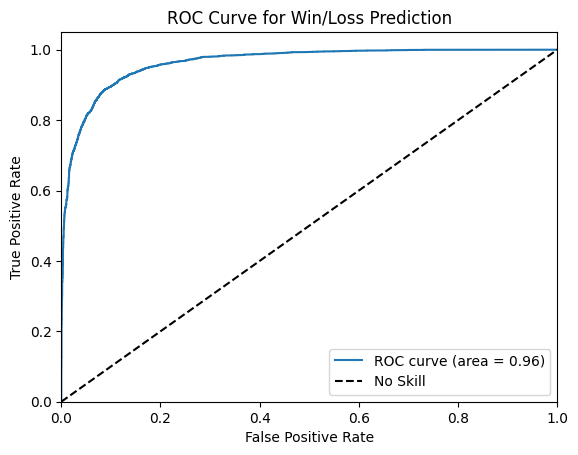

In [41]:
y_pred_proba = knn_best.predict_proba(X_test_scaled)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Win/Loss Prediction')
plt.legend()
plt.show()